### Deliverable 1: Preprocessing the Data for a Neural Network

In [2]:
# Import our dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, Adamax, Adagrad
from keras.layers import LeakyReLU
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Import and read the charity_data.csv.
application_df = pd.read_csv("./Resources/charity_data.csv")
display(application_df.shape, application_df.head())

(34299, 12)

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:
# Check distribution of each numerical column
application_df.describe()

,EIN,STATUS,ASK_AMT,IS_SUCCESSFUL
count,3.429900e+04,34299.000000,3.429900e+04,34299.000000
mean,5.191852e+08,0.999854,2.769199e+06,0.532406
std,2.451472e+08,0.012073,8.713045e+07,0.498956
min,1.052060e+07,0.000000,5.000000e+03,0.000000
25%,2.748482e+08,1.000000,5.000000e+03,0.000000
50%,4.656317e+08,1.000000,5.000000e+03,1.000000
75%,7.526117e+08,1.000000,7.742000e+03,1.000000
max,9.960869e+08,1.000000,8.597806e+09,1.000000


In [5]:
# Check why STATUS is so imbalanced and if we should drop STATUS
application_df.groupby('STATUS').count()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
STATUS,,,,,,,,,,,
0,5,5,5,5,5,5,5,5,5,5,5
1,34294,34294,34294,34294,34294,34294,34294,34294,34294,34294,34294


In [6]:
# Drop the non-beneficial ID columns, 'EIN' and 'STATUS'.
application_df = application_df.drop(columns=['EIN', 'STATUS'])

In [7]:
# Determine the number of unique values in each column.
application_df.nunique()

NAME                      19568
APPLICATION_TYPE             17
AFFILIATION                   6
CLASSIFICATION               71
USE_CASE                      5
ORGANIZATION                  4
INCOME_AMT                    9
SPECIAL_CONSIDERATIONS        2
ASK_AMT                    8747
IS_SUCCESSFUL                 2
dtype: int64

In [8]:
# Look at APPLICATION_TYPE value counts for binning
app_counts = application_df.APPLICATION_TYPE.value_counts()
app_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot: title={'center': 'Knee Point of APPLICATION_TYPE Counts'}, xlabel='APPLICATION_TYPE'>

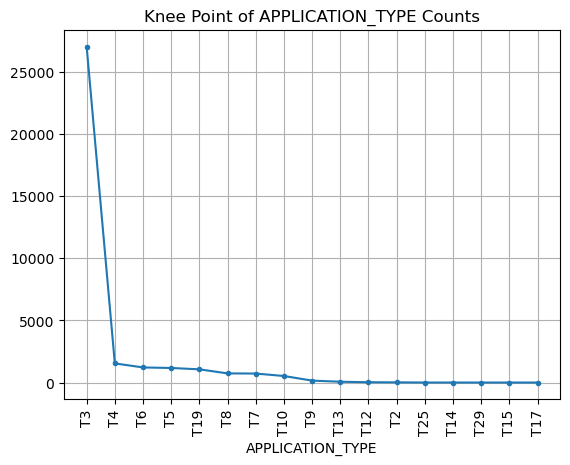

In [9]:
# Visualize the value counts of APPLICATION_TYPE
app_counts.plot.line(xlabel='APPLICATION_TYPE', title='Knee Point of APPLICATION_TYPE Counts', \
  xticks=range(0, len(app_counts)), rot=90, marker='.', grid=True)

In [10]:
# Determine which values to replace if counts are less than 528
replace_application = app_counts[app_counts < 737].index

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app, "Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
Other     1529
T6        1216
T5        1173
T19       1065
T8         737
Name: APPLICATION_TYPE, dtype: int64

In [11]:
# Look at CLASSIFICATION value counts for binning
clf_counts = application_df.CLASSIFICATION.value_counts()
clf_counts[0:10]

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
C7000      777
C1700      287
C4000      194
C5000      116
C1270      114
Name: CLASSIFICATION, dtype: int64

<AxesSubplot: title={'center': 'Density Plot of CLASSIFICATION Counts'}, ylabel='Density'>

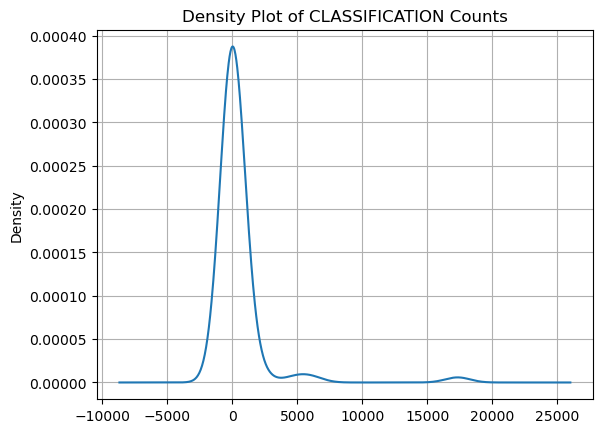

In [12]:
# Visualize the value counts of CLASSIFICATION
clf_counts.plot.density(title='Density Plot of CLASSIFICATION Counts', grid=True)

In [13]:
# Determine which values to replace if counts are less than 1000
replace_class = clf_counts[clf_counts < 777].index

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls, "Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
Other     1484
C7000      777
Name: CLASSIFICATION, dtype: int64

In [14]:
# Look at NAME value counts for binning
name_counts = application_df.NAME.value_counts()
name_counts[0:10]

PARENT BOOSTER USA INC                               1260
TOPS CLUB INC                                         765
UNITED STATES BOWLING CONGRESS INC                    700
WASHINGTON STATE UNIVERSITY                           492
AMATEUR ATHLETIC UNION OF THE UNITED STATES INC       408
PTA TEXAS CONGRESS                                    368
SOROPTIMIST INTERNATIONAL OF THE AMERICAS INC         331
ALPHA PHI SIGMA                                       313
TOASTMASTERS INTERNATIONAL                            293
MOST WORSHIPFUL STRINGER FREE AND ACCEPTED MASONS     287
Name: NAME, dtype: int64

<AxesSubplot: title={'center': 'Density Plot of NAME Counts'}, ylabel='Density'>

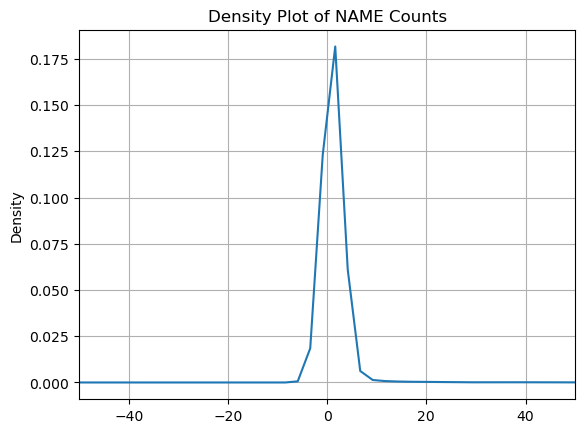

In [15]:
# Visualize the value counts of NAME
name_counts.plot.density(title='Density Plot of NAME Counts', grid=True, xlim=(-50, 50))

In [16]:
# Determine which values to replace
replace_name = name_counts[name_counts < 10].index

# Replace in dataframe
for name in replace_name:
    application_df.NAME = application_df.NAME.replace(name, "Other")
    
# Check to make sure binning was successful
application_df.NAME.value_counts()

Other                                      21022
PARENT BOOSTER USA INC                      1260
TOPS CLUB INC                                765
UNITED STATES BOWLING CONGRESS INC           700
WASHINGTON STATE UNIVERSITY                  492
                                           ...  
CASCADE 4-H FOUNDATION                        10
FREE & ACCEPTED MASONS OF WASHINGTON          10
NEW MEXICO GARDEN CLUBS INC                   10
NATIONAL ASSOCIATION OF HISPANIC NURSES       10
UNION OF CALIFORNIA STATE WORKERS             10
Name: NAME, Length: 223, dtype: int64

In [17]:
# Check the number of unique values in each column after binning optimization
application_df.nunique()

NAME                       223
APPLICATION_TYPE             7
AFFILIATION                  6
CLASSIFICATION               7
USE_CASE                     5
ORGANIZATION                 4
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [18]:
# Generate our categorical variable lists
# list() is optional because all categorical elements are homogeneous and of the same data type (object).
application_cat = list(application_df.select_dtypes(include=['object']).columns)
application_cat

['NAME',
 'APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [19]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(application_cat)
encode_df.head()

,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES INC,NAME_AMERICAN ART THERAPY ASSOCIATION INC,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True)
application_df = application_df.drop(application_cat, axis=1)
display(application_df.shape, application_df.head())

(34299, 265)

,ASK_AMT,IS_SUCCESSFUL,NAME_ACE MENTOR PROGRAM OF AMERICA INC,NAME_AIR FORCE ASSOCIATION,NAME_ALABAMA FEDERATION OF WOMENS CLUBS,NAME_ALABAMA TREASURE FOREST ASSOCIATION,NAME_ALPHA PHI SIGMA,NAME_ALPHA PHI SIGMA INC,NAME_ALTRUSA INTERNATIONAL FOUNDATION INC,NAME_AMATEUR ATHLETIC UNION OF THE UNITED STATES,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,5000,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,108590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,5000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,6692,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,142590,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
# Optimize numeric columns
int_cols = list(application_df.select_dtypes(include=['int']).columns)
application_df[int_cols].describe()

,ASK_AMT,IS_SUCCESSFUL
count,3.429900e+04,34299.000000
mean,2.769199e+06,0.532406
std,8.713045e+07,0.498956
min,5.000000e+03,0.000000
25%,5.000000e+03,0.000000
50%,5.000000e+03,1.000000
75%,7.742000e+03,1.000000
max,8.597806e+09,1.000000


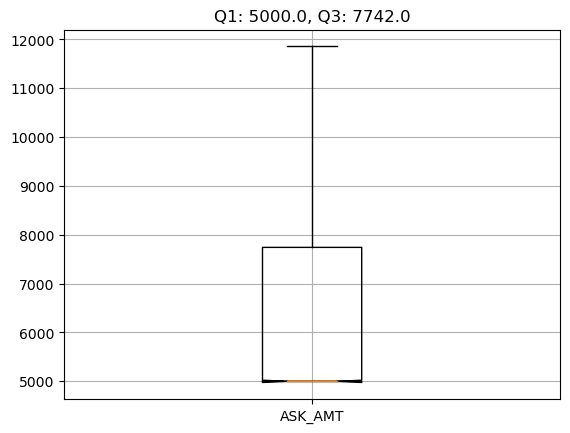

In [22]:
# Create a box-and-whisker plot for int columns
plt_data = application_df['ASK_AMT']
fig, ax = plt.subplots()
boxplt = ax.boxplot(plt_data, labels=['ASK_AMT'], showfliers=False, showcaps=True, notch=True, widths=0.2)
# print the 1st and 3rd quartile
iqrs = [item.get_ydata() for item in boxplt['whiskers']]
ax.set_title(f'Q1: {iqrs[:2][0][0]}, Q3: {iqrs[:2][1][0]}')
ax.grid()
# Save the figure.
# plt.savefig('./Data/ASK_AMT_notshowfliers_boxplot.png', bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()

In [23]:
# remove fliers (accuracy ~ 75.5%)
q3, q1 = plt_data.quantile([0.75, 0.25])
stddev = plt_data.std()
application_df = application_df[plt_data <= (q3 + 1.5*(q3-q1))]
# application_df = application_df[np.abs((plt_data - plt_data.mean())) <= (3*stddev)]
application_df.shape

(26093, 265)

In [24]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"], axis=1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [25]:
# Create a StandardScaler instances
scaler = StandardScaler()
# scaler = MinMaxScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Deliverable 3: Compile, Train and Evaluate the Model with Optimized Hidden Layer & Neurons per Layer

In [26]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
n_input_features = len(X_train_scaled[0])
n_hidden_layer1 = round(0.9 * n_input_features)
n_hidden_layer2 = round(0.5 * n_input_features)
n_hidden_layer3 = round(0.9 * n_input_features)
# Define the model epoch and callback's saving period
epochn = 200
periodn = 25
batchn = 32

# Reusable func to easily eval nn model (n*: number of nodes in each hidden layer, actf*: activation function)
def eval_nn(n1=n_hidden_layer1, n2=n_hidden_layer2, n3=n_hidden_layer3, actf1='tanh', actf2='tanh', actf3='', epochn=epochn):
    # define nn model
    nn = tf.keras.models.Sequential()

    # First hidden layer
    if actf1.lower().startswith('leaky'):
        nn.add(tf.keras.layers.Dense(units=n1, input_dim=n_input_features, activation=LeakyReLU(alpha=0.01)))
    else:
        nn.add(tf.keras.layers.Dense(units=n1, input_dim=n_input_features, activation=actf1))

    # Second hidden layer
    if actf2 != '':
        if actf2.lower().startswith('leaky'):
            nn.add(tf.keras.layers.Dense(units=n2, activation=LeakyReLU(alpha=0.01)))
        else:
            nn.add(tf.keras.layers.Dense(units=n2, activation=actf2))
    else:
        n2 = ''

    # Third hidden layer
    if actf3 != '':
        if actf3.lower().startswith('leaky'):
            nn.add(tf.keras.layers.Dense(units=n3, activation=LeakyReLU(alpha=0.01)))
        else:
            nn.add(tf.keras.layers.Dense(units=n3, activation=actf3))
    else:
        n3 = ''

    # Output layer
    nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Check the structure of the model
    print(n_input_features, n1, n2, n3)
    nn_sum = nn.summary()
    return (nn, nn_sum, n1, n2, n3, actf1, actf2, actf3, epochn)

In [27]:
# Define hyper-parameter and a callback that triggers EarlyStopping
optx = Adam(learning_rate=0.001, epsilon=1e-7)
callback = EarlyStopping(monitor='loss', patience=3)

# Eval nn model using default nodes of 0.7x-2x inputs in hidden layer1-3, default activation function relu+relu+sigmoid
nn, nn_sum, n1, n2, n3, actf1, actf2, actf3, epochn = eval_nn()

264 238 132 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 238)               63070     
                                                                 
 dense_1 (Dense)             (None, 132)               31548     
                                                                 
 dense_2 (Dense)             (None, 1)                 133       
                                                                 
Total params: 94,751
Trainable params: 94,751
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Define the checkpoint path and filenames
checkpoint_path = "checkpoints_dnn_testrun_" + actf1
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_files = checkpoint_path + "/weights_{epoch:03d}.hdf5"

In [29]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer=optx, metrics=["accuracy", "mse"])
print(nn.optimizer.get_config())
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(filepath=checkpoint_files, verbose=1, save_weights_only=True, save_freq='epoch', period=periodn)


{'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [30]:
# Train the model (with ModelCheckpoint)
fit_model = nn.fit(X_train_scaled, y_train, batch_size=batchn, epochs=epochn, callbacks=[cp_callback])

Epoch 1/200
612/612 [==============================] - 7s 7ms/step - loss: 0.4377 - accuracy: 0.7968 - mse: 0.1435
Epoch 2/200
612/612 [==============================] - 4s 7ms/step - loss: 0.4093 - accuracy: 0.8075 - mse: 0.1344
Epoch 3/200
612/612 [==============================] - 4s 7ms/step - loss: 0.4041 - accuracy: 0.8117 - mse: 0.1327
Epoch 4/200
612/612 [==============================] - 4s 7ms/step - loss: 0.3989 - accuracy: 0.8127 - mse: 0.1309
Epoch 5/200
612/612 [==============================] - 4s 7ms/step - loss: 0.3974 - accuracy: 0.8134 - mse: 0.1304
Epoch 6/200
612/612 [==============================] - 4s 6ms/step - loss: 0.3959 - accuracy: 0.8170 - mse: 0.1298
Epoch 7/200
612/612 [==============================] - 4s 6ms/step - loss: 0.3948 - accuracy: 0.8169 - mse: 0.1294
Epoch 8/200
612/612 [==============================] - 4s 6ms/step - loss: 0.3934 - accuracy: 0.8162 - mse: 0.1291
Epoch 9/200
612/612 [==============================] - 4s 7ms/step - loss: 0.392

In [31]:
# Evaluate the model using the test/train data
model_loss, model_accuracy, model_mse = nn.evaluate(X_test_scaled, y_test, verbose=2)
train_model_loss, train_model_accuracy, train_model_mse = nn.evaluate(X_train_scaled, y_train, verbose=2)
print(f"[Test data ] Loss: {model_loss}, Accuracy: {model_accuracy}, MSE: {model_mse}", \
  f"\n[Train data] Loss: {train_model_loss}, Accuracy: {train_model_accuracy}, MSE: {train_model_mse}")

204/204 - 2s - loss: 0.4252 - accuracy: 0.8101 - mse: 0.1342 - 2s/epoch - 11ms/step
612/612 - 2s - loss: 0.3717 - accuracy: 0.8275 - mse: 0.1224 - 2s/epoch - 4ms/step
[Test data ] Loss: 0.42515841126441956, Accuracy: 0.8100858330726624, MSE: 0.13422039151191711 
[Train data] Loss: 0.37172380089759827, Accuracy: 0.8274822235107422, MSE: 0.12235801666975021


In [32]:
# Export our model to HDF5 file
nn.save(checkpoint_path + "/AlphabetSoupCharity_Optimization1.h5")

In [33]:
# Create a DataFrame containing training history
history1_df = pd.DataFrame(fit_model.history, index=range(1, len(fit_model.history["loss"])+1))
legend1 = f'{actf1}{n1}_{actf2}{n2}_{actf3}{n3}_sigmoid_Adam'

### Deliverable 3: DNN Model using 2 hidden layer tanh

In [34]:
# Define hyper-parameter and a callback that triggers EarlyStopping
optx = Adamax(learning_rate=0.001, epsilon=1e-7)
callback = EarlyStopping(monitor='loss', patience=3)

# Eval nn model using default nodes of 0.7x-2x inputs in hidden layer1/2, default activation function relu+relu+sigmoid
nn, nn_sum, n1, n2, n3, actf1, actf2, actf3, epochn = eval_nn(n_hidden_layer1, n_hidden_layer2, n_hidden_layer3, 'tanh', 'tanh', '')

264 238 132 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 238)               63070     
                                                                 
 dense_4 (Dense)             (None, 132)               31548     
                                                                 
 dense_5 (Dense)             (None, 1)                 133       
                                                                 
Total params: 94,751
Trainable params: 94,751
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Define the checkpoint path and filenames
checkpoint_path = "checkpoints_dnn_testrun_" + actf1
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_files = checkpoint_path + "/weights_{epoch:03d}.hdf5"

In [36]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer=optx, metrics=["accuracy", "mse"])
print(nn.optimizer.get_config())
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(filepath=checkpoint_files, verbose=1, save_weights_only=True, save_freq='epoch', period=periodn)

{'name': 'Adamax', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07}


In [37]:
# Train the model (with ModelCheckpoint)
fit_model = nn.fit(X_train_scaled, y_train, batch_size=batchn, epochs=epochn, callbacks=[cp_callback])

Epoch 1/200
612/612 [==============================] - 4s 5ms/step - loss: 0.4413 - accuracy: 0.7956 - mse: 0.1444
Epoch 2/200
612/612 [==============================] - 4s 6ms/step - loss: 0.4105 - accuracy: 0.8087 - mse: 0.1347
Epoch 3/200
612/612 [==============================] - 4s 7ms/step - loss: 0.4054 - accuracy: 0.8104 - mse: 0.1332
Epoch 4/200
612/612 [==============================] - 3s 5ms/step - loss: 0.4030 - accuracy: 0.8101 - mse: 0.1327
Epoch 5/200
612/612 [==============================] - 4s 6ms/step - loss: 0.4022 - accuracy: 0.8115 - mse: 0.1324
Epoch 6/200
612/612 [==============================] - 4s 7ms/step - loss: 0.3999 - accuracy: 0.8125 - mse: 0.1317
Epoch 7/200
612/612 [==============================] - 4s 7ms/step - loss: 0.3988 - accuracy: 0.8141 - mse: 0.1312
Epoch 8/200
612/612 [==============================] - 4s 7ms/step - loss: 0.3968 - accuracy: 0.8128 - mse: 0.1305
Epoch 9/200
612/612 [==============================] - 4s 7ms/step - loss: 0.396

In [38]:
# Evaluate the model using the test/train data
model_loss, model_accuracy, model_mse = nn.evaluate(X_test_scaled, y_test, verbose=2)
train_model_loss, train_model_accuracy, train_model_mse = nn.evaluate(X_train_scaled, y_train, verbose=2)
print(f"[Test data ] Loss: {model_loss}, Accuracy: {model_accuracy}, MSE: {model_mse}", \
  f"\n[Train data] Loss: {train_model_loss}, Accuracy: {train_model_accuracy}, MSE: {train_model_mse}")

204/204 - 1s - loss: 0.4150 - accuracy: 0.8118 - mse: 0.1326 - 674ms/epoch - 3ms/step
612/612 - 3s - loss: 0.3710 - accuracy: 0.8268 - mse: 0.1219 - 3s/epoch - 4ms/step
[Test data ] Loss: 0.41504812240600586, Accuracy: 0.8117719292640686, MSE: 0.13255570828914642 
[Train data] Loss: 0.3709520995616913, Accuracy: 0.826766848564148, MSE: 0.12185210734605789


In [39]:
# Export our model to HDF5 file
nn.save(checkpoint_path + "/AlphabetSoupCharity_Optimization1.h5")

In [40]:
# Create a DataFrame containing training history
history2_df = pd.DataFrame(fit_model.history, index=range(1, len(fit_model.history["loss"])+1))
legend2 = f'{actf1}{n1}_{actf2}{n2}_{actf3}{n3}_sigmoid_Adamax'

### Deliverable 3: DNN Model using 3 hidden layers tanh

In [41]:
# Define hyper-parameter and a callback that triggers EarlyStopping
optx = Adam(learning_rate=0.001, epsilon=1e-7)
callback = EarlyStopping(monitor='loss', patience=3)

# Eval nn model using default nodes of 0.7x-2x inputs in hidden layer1/2, default activation function relu+relu+sigmoid
nn, nn_sum, n1, n2, n3, actf1, actf2, actf3, epochn = eval_nn(n_hidden_layer1, n_hidden_layer2, n_hidden_layer3, 'tanh', 'tanh', 'LeakyReLU')

264 238 132 238
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 238)               63070     
                                                                 
 dense_7 (Dense)             (None, 132)               31548     
                                                                 
 dense_8 (Dense)             (None, 238)               31654     
                                                                 
 dense_9 (Dense)             (None, 1)                 239       
                                                                 
Total params: 126,511
Trainable params: 126,511
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Define the checkpoint path and filenames
checkpoint_path = "checkpoints_dnn_testrun_" + actf1
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_files = checkpoint_path + "/weights_{epoch:03d}.hdf5"

In [43]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer=optx, metrics=["accuracy", "mse"])
print(nn.optimizer.get_config())
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(filepath=checkpoint_files, verbose=1, save_weights_only=True, save_freq='epoch', period=periodn)

{'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [44]:
# Train the model (with ModelCheckpoint)
fit_model = nn.fit(X_train_scaled, y_train, batch_size=batchn, epochs=epochn, callbacks=[cp_callback])

Epoch 1/200
612/612 [==============================] - 7s 8ms/step - loss: 0.4311 - accuracy: 0.8020 - mse: 0.1408
Epoch 2/200
612/612 [==============================] - 3s 6ms/step - loss: 0.4057 - accuracy: 0.8110 - mse: 0.1328
Epoch 3/200
612/612 [==============================] - 4s 6ms/step - loss: 0.4017 - accuracy: 0.8135 - mse: 0.1316
Epoch 4/200
612/612 [==============================] - 5s 7ms/step - loss: 0.3987 - accuracy: 0.8149 - mse: 0.1307
Epoch 5/200
612/612 [==============================] - 4s 7ms/step - loss: 0.3971 - accuracy: 0.8150 - mse: 0.1303
Epoch 6/200
612/612 [==============================] - 5s 8ms/step - loss: 0.3960 - accuracy: 0.8164 - mse: 0.1299
Epoch 7/200
612/612 [==============================] - 5s 9ms/step - loss: 0.3940 - accuracy: 0.8172 - mse: 0.1293
Epoch 8/200
612/612 [==============================] - 5s 9ms/step - loss: 0.3940 - accuracy: 0.8154 - mse: 0.1293
Epoch 9/200
612/612 [==============================] - 4s 6ms/step - loss: 0.392

In [45]:
# Evaluate the model using the test/train data
model_loss, model_accuracy, model_mse = nn.evaluate(X_test_scaled, y_test, verbose=2)
train_model_loss, train_model_accuracy, train_model_mse = nn.evaluate(X_train_scaled, y_train, verbose=2)
print(f"[Test data ] Loss: {model_loss}, Accuracy: {model_accuracy}, MSE: {model_mse}", \
  f"\n[Train data] Loss: {train_model_loss}, Accuracy: {train_model_accuracy}, MSE: {train_model_mse}")

204/204 - 1s - loss: 0.4446 - accuracy: 0.8073 - mse: 0.1352 - 852ms/epoch - 4ms/step
612/612 - 2s - loss: 0.3707 - accuracy: 0.8246 - mse: 0.1221 - 2s/epoch - 3ms/step
[Test data ] Loss: 0.4445861279964447, Accuracy: 0.8073267936706543, MSE: 0.13518624007701874 
[Train data] Loss: 0.3706672489643097, Accuracy: 0.8245694637298584, MSE: 0.1220613569021225


In [46]:
# Export our model to HDF5 file
nn.save(checkpoint_path + "/AlphabetSoupCharity_Optimization1.h5")

In [47]:
# Create a DataFrame containing training history
history3_df = pd.DataFrame(fit_model.history, index=range(1, len(fit_model.history["loss"])+1))
legend3 = f'{actf1}{n1}_{actf2}{n2}_{actf3}{n3}_sigmoid_Adam'

### Deliverable 3: DNN Model using 3 hidden layers tanh and softmax

In [48]:
# Define hyper-parameter and a callback that triggers EarlyStopping
optx = Adamax(learning_rate=0.001, epsilon=1e-7)
callback = EarlyStopping(monitor='loss', patience=3)

# Eval nn model using default nodes of 0.7x-2x inputs in hidden layer1/2, default activation function relu+relu+sigmoid
nn, nn_sum, n1, n2, n3, actf1, actf2, actf3, epochn = eval_nn(n_hidden_layer1, n_hidden_layer2, n_hidden_layer3, 'tanh', 'tanh', 'LeakyReLU')

264 238 132 238
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 238)               63070     
                                                                 
 dense_11 (Dense)            (None, 132)               31548     
                                                                 
 dense_12 (Dense)            (None, 238)               31654     
                                                                 
 dense_13 (Dense)            (None, 1)                 239       
                                                                 
Total params: 126,511
Trainable params: 126,511
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Define the checkpoint path and filenames
checkpoint_path = "checkpoints_dnn_testrun_" + actf1
os.makedirs(checkpoint_path, exist_ok=True)
checkpoint_files = checkpoint_path + "/weights_{epoch:03d}.hdf5"

In [50]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer=optx, metrics=["accuracy", "mse"])
print(nn.optimizer.get_config())
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(filepath=checkpoint_files, verbose=1, save_weights_only=True, save_freq='epoch', period=periodn)

{'name': 'Adamax', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': False, 'is_legacy_optimizer': False, 'learning_rate': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07}


In [51]:
# Train the model (with ModelCheckpoint)
fit_model = nn.fit(X_train_scaled, y_train, batch_size=batchn, epochs=epochn, callbacks=[cp_callback])

Epoch 1/200
612/612 [==============================] - 5s 5ms/step - loss: 0.4362 - accuracy: 0.7996 - mse: 0.1420
Epoch 2/200
612/612 [==============================] - 3s 4ms/step - loss: 0.4048 - accuracy: 0.8115 - mse: 0.1323
Epoch 3/200
612/612 [==============================] - 3s 5ms/step - loss: 0.4001 - accuracy: 0.8143 - mse: 0.1312
Epoch 4/200
612/612 [==============================] - 3s 5ms/step - loss: 0.3981 - accuracy: 0.8154 - mse: 0.1306
Epoch 5/200
612/612 [==============================] - 3s 5ms/step - loss: 0.3962 - accuracy: 0.8149 - mse: 0.1301
Epoch 6/200
612/612 [==============================] - 3s 4ms/step - loss: 0.3956 - accuracy: 0.8150 - mse: 0.1301
Epoch 7/200
612/612 [==============================] - 3s 5ms/step - loss: 0.3948 - accuracy: 0.8160 - mse: 0.1297
Epoch 8/200
612/612 [==============================] - 3s 5ms/step - loss: 0.3938 - accuracy: 0.8165 - mse: 0.1293
Epoch 9/200
612/612 [==============================] - 3s 5ms/step - loss: 0.392

In [52]:
# Evaluate the model using the test/train data
model_loss, model_accuracy, model_mse = nn.evaluate(X_test_scaled, y_test, verbose=2)
train_model_loss, train_model_accuracy, train_model_mse = nn.evaluate(X_train_scaled, y_train, verbose=2)
print(f"[Test data ] Loss: {model_loss}, Accuracy: {model_accuracy}, MSE: {model_mse}", \
  f"\n[Train data] Loss: {train_model_loss}, Accuracy: {train_model_accuracy}, MSE: {train_model_mse}")

204/204 - 1s - loss: 0.4431 - accuracy: 0.8093 - mse: 0.1339 - 508ms/epoch - 2ms/step
612/612 - 1s - loss: 0.3684 - accuracy: 0.8276 - mse: 0.1212 - 1s/epoch - 2ms/step
[Test data ] Loss: 0.44308575987815857, Accuracy: 0.8093194365501404, MSE: 0.13391584157943726 
[Train data] Loss: 0.36835819482803345, Accuracy: 0.8276355266571045, MSE: 0.12119592726230621


In [53]:
# Export our model to HDF5 file
nn.save(checkpoint_path + "/AlphabetSoupCharity_Optimization1.h5")

In [54]:
# Create a DataFrame containing training history
history4_df = pd.DataFrame(fit_model.history, index=range(1, len(fit_model.history["loss"])+1))
legend4 = f'{actf1}{n1}_{actf2}{n2}_{actf3}{n3}_sigmoid_Adamax'

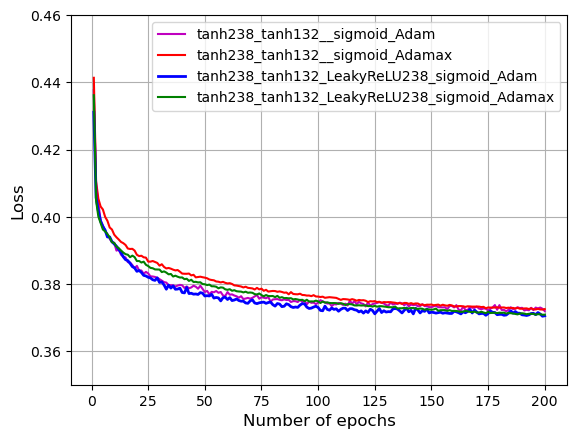

In [58]:
# Plot the loss
x = history1_df.index
plt.plot(x, history1_df['loss'], label=legend1, c='m')
plt.plot(x, history2_df['loss'], label=legend2, c='r')
plt.plot(x, history3_df['loss'], label=legend3, c='b', lw=2)
plt.plot(x, history4_df['loss'], label=legend4, c='g')
plt.legend(loc='upper right')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.ylim([0.35, 0.46])
plt.grid()
# Save the figure.
plt.savefig(f'Data/LossCurve_DNN_testrun_{legend3}_{epochn}.png', bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()

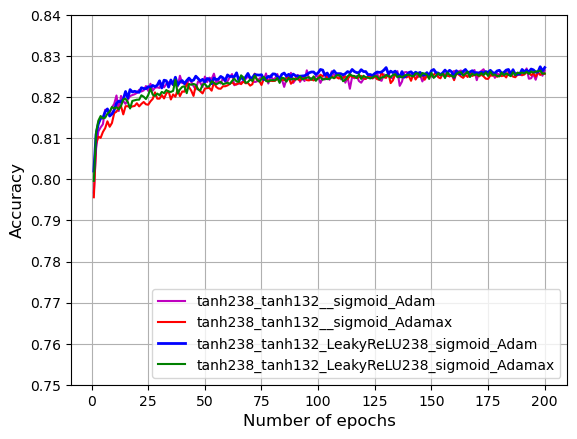

In [61]:
# # Plot the accuracy
plt.plot(x, history1_df['accuracy'], label=legend1, c='m')
plt.plot(x, history2_df['accuracy'], label=legend2, c='r')
plt.plot(x, history3_df['accuracy'], label=legend3, c='b', lw=2)
plt.plot(x, history4_df['accuracy'], label=legend4, c='g')
plt.legend(loc='lower right')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim([0.75, 0.84])
plt.grid()
# Save the figure.
plt.savefig(f'Data/AccuracyCurve_DNN_testrun_{legend3}_{epochn}.png', bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()

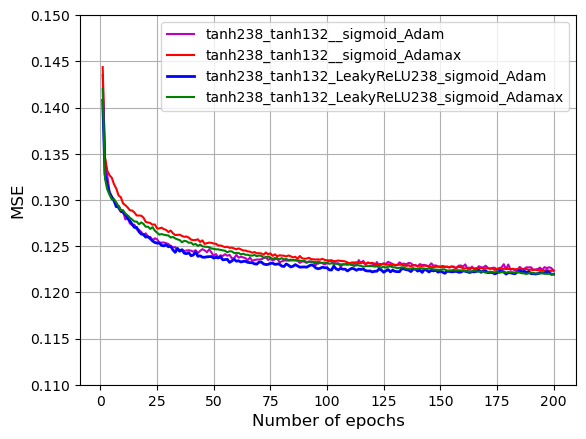

In [59]:
# # Plot the MSE
plt.plot(x, history1_df['mse'], label=legend1, c='m')
plt.plot(x, history2_df['mse'], label=legend2, c='r')
plt.plot(x, history3_df['mse'], label=legend3, c='b', lw=2)
plt.plot(x, history4_df['mse'], label=legend4, c='g')
plt.legend(loc='upper right')
plt.xlabel('Number of epochs', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.ylim([0.11, 0.15])
plt.grid()
# Save the figure.
plt.savefig(f'Data/MSECurve_DNN_testrun_{legend3}_{epochn}.png', bbox_inches='tight', facecolor='w')
# Show Figure
plt.show()